In [95]:
from astropy.io import fits
import numpy as np
from astropy.table import Table, Column

In [96]:
# imaging with more data; template from wk2 folder
import astropy 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import ascii
from scipy.signal import convolve2d
import sys
import os


# FWHM = 0.07913  / 12   # psf HWHM is an assumption
# sigma_FWHM = FWHM / 2.355
# HWHM = FWHM / 2
# sigma_HWHM = HWHM/ 1.177


more_data = open('/Users/nicholebarry/MWA/data/Deconvolution/observation_ids.txt', 'r')
component_array = [line.split( ) for line in more_data.readlines()]
    
for i in component_array:
    components = '/Users/nicholebarry/MWA/data/Deconvolution/' + i[0] +'_components.fits'
    hdu_list = fits.open(components, memmap=True)

    info_array = hdu_list[1].data

    ra = info_array['RIGHTASCENSION']
    dec = info_array['DECLINATION']
    flux = info_array['FLUXI']
    #used eyed instead of id since id is already a taken name
    eyed = info_array['ID']
    beam = info_array['BEAM']

    
    # appropriate range for ra is [340,10] which goes over the 360 boundary, to mitigate this we add an offset such that the effective ra range is [-20, 10]!
    ra[ra>180] -= 360


    # here i am setting up the initial data in the array by putting the data from the first fits file in the array.
    if component_array[0] == i:
        ra_overall = ra
        dec_overall = dec
        eyed_overall = eyed
        flux_overall = flux
        beam_overall = beam
    #for all else, it appends to the new variable to make a REALLY BIG ARRAY OF EVERYTHING EVER
    else:
        ra_overall = np.append(ra_overall, ra)
        dec_overall = np.append(dec_overall, dec)
        eyed_overall = np.append(eyed_overall, eyed)
        flux_overall = np.append(flux_overall, flux)
        beam_overall = np.append(beam_overall, beam)



#represents the total number of observations
n_obs = len(component_array)

def pixelate(ra_zoom, dec_zoom, n_bins, ra_overall, dec_overall, eyed_overall, flux_overall):

    #Check to see which dimension is larger so that a square in ra,dec can 
    #be returned
    if (ra_zoom[1]-ra_zoom[0]) > (dec_zoom[1]-dec_zoom[0]):
        zoom = ra_zoom
    else:
        zoom = dec_zoom

    #Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1]-zoom[0])/n_bins

    #Create arrays for ra and dec that give the left side of each pixel
    ra_bin_array = np.multiply(range(n_bins), binsize) + ra_zoom[0]
    dec_bin_array = np.multiply(range(n_bins), binsize) + dec_zoom[0]

    #Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(ra_bin_array),len(dec_bin_array)))

    #Histogram components into ra bins
    ra_histogram = np.digitize(ra_overall,ra_bin_array)

    #Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(ra_bin_array)):

        #Find the indices that fall into the current ra bin slice
        ra_inds = np.where(ra_histogram == bin_i)

        #Go to next for cycle if no indices fall into current ra bin slice
        if len(ra_inds) == 0:
            continue

        #Histogram components that fall into the current ra bin slice by dec
        dec_histogram = np.digitize(dec_overall[ra_inds],dec_bin_array)

        #Begin for loop by dec over ra bin slice
        for bin_j in range(len(dec_bin_array)):
            
            #Find the indicies that fall into the current dec bin
            dec_inds = np.where(dec_histogram == bin_j)

            #Go to next for cycle if no indices fall into current dec bin
            if len(dec_inds) == 0:
                continue

            #Sum the flux components that fall into current ra/dec bin
            pixels[bin_i,bin_j] = np.sum(flux_overall[(ra_inds[0])[dec_inds[0]]])

    #Find the pixel centers in ra/dec for plotting purposes
    ra_pixel_centers = np.multiply(range(n_bins),binsize) + ra_zoom[0] + binsize/2.
    dec_pixel_centers = np.multiply(range(n_bins),binsize) + dec_zoom[0] + binsize/2.

    return pixels, ra_pixel_centers, dec_pixel_centers

In [101]:
def gaussian_kernel(size, new_sigma):
    # make 1D array of equally spaced intervals
    array = np.linspace((-(size - 1) / 2), ((size - 1) / 2), size)
    # turns 1D array into 2D Kernel thingy
    x, y = np.meshgrid(array, array)
    kernel = np.exp(-0.5 * (np.square(x) + np.square(y)) / np.square(new_sigma))
    amplitutde = 1/(np.square(new_sigma)*2*np.pi)
    #print("exp:",( -0.5 * (np.square(x) + np.square(y)) / np.square(new_sigma)))
    #print("kernel\n", kernel)
    s = kernel #/ np.sum(kernel)
    amp = s * amplitutde

    print("normalized ker mult. amplitude :\n", amp)
    return amp

divider = 8
FWHM = 0.07913  / divider  # psf HWHM is an assumption 8, 24
sigma_FWHM = FWHM / 2.355


#for loop here to loop through all the sources
#centre the sources so each source is the same number of pixels and therefore has the same ra and dec [5.95, 6.05]

ra_sources = [[5.75, 5.84], [3.15, 3.375], [2.50, 2.60], [0.83, 0.97], [-2.35, -2.25], [-11.10, -10.90], [-10.125, -9.90], [5.94, 6.06], [-1.00, -0.50], [11.75, 12.05]]
dec_sources = [[-25.09,-25], [-28.75,-28.525], [-29.34,-29.24],[-27.48,-27.34],[-25,-24.9], [-28.5,-28.3],[-27.575,-27.35 ], [-30.42,-30.3],[-35,-34.5], [-25.45, -25.15]]
n_bins = 150 

#create a loop to find the difference between the 2nd and first components of each element in the array to find the degree range
degree_range = []
for pair in dec_sources:
    diff = pair[1] - pair[0]
    degree_range.append(diff)

counter = 0


for ra_zoom, dec_zoom in zip(ra_sources, dec_sources):

    range_of_ra_dec = np.where((ra_overall >= ra_zoom[0]) & (ra_overall <= ra_zoom[1]) & (dec_overall >= dec_zoom[0]) & (dec_overall <= dec_zoom[1]))
    
    new_ra = ra_overall[range_of_ra_dec]
    new_dec = dec_overall[range_of_ra_dec]
    new_flux = flux_overall[range_of_ra_dec]
    new_eyed = eyed_overall[range_of_ra_dec]
    new_beam = beam_overall[range_of_ra_dec]


    (pixels, ra_pixel_centers, dec_pixel_centers) = pixelate(ra_zoom, dec_zoom, n_bins, new_ra, new_dec, new_eyed, new_flux)

    pixels2 = pixels / n_obs
    num = np.size(pixels2)
    

# divide num of pixels by the degree range so wehave pixels/deg then multiply with sigma_HWHM so we have the sigma in the unit of pixels then pass that through the function
   # max_sigma = 1.33
    new_sigma =  (np.sqrt(num) / (degree_range[counter]) * (sigma_FWHM))
    counter += 1
    print("new_sigma = ", new_sigma)
    size = 90
    kernel = gaussian_kernel(size, new_sigma)
    kernel_sum = np.sum(kernel)
    print("ker", kernel_sum)
    print("flux sum: ", np.sum(pixels2))
    conv_image = convolve2d(pixels2,kernel, mode="same")
    print("tot flux", np.sum(conv_image))


    with open('/Users/nicholebarry/MWA/data/Deconvolution/flux_data_'+ str(divider) +'_'+ str(size)+'.txt', 'a') as file:
    # Iterate through the pixel centers and their corresponding flux values
    # Write source information
        file.write(f"source {counter}\n")
        for i, ra in enumerate(ra_pixel_centers):
            for j, dec in enumerate(dec_pixel_centers):
                flux_value = conv_image[i, j]
                #flux_value = pixels2[i, j]
            # Write the RA, Dec, and flux value to the file
                file.write(f"{ra}, {dec}, {flux_value}\n")



new_sigma =  7.000176928520889
normalized ker mult. amplitude :
 [[9.14599964e-21 2.24486477e-20 5.39866633e-20 ... 5.39866633e-20
  2.24486477e-20 9.14599964e-21]
 [2.24486477e-20 5.50996945e-20 1.32509035e-19 ... 1.32509035e-19
  5.50996945e-20 2.24486477e-20]
 [5.39866633e-20 1.32509035e-19 3.18670449e-19 ... 3.18670449e-19
  1.32509035e-19 5.39866633e-20]
 ...
 [5.39866633e-20 1.32509035e-19 3.18670449e-19 ... 3.18670449e-19
  1.32509035e-19 5.39866633e-20]
 [2.24486477e-20 5.50996945e-20 1.32509035e-19 ... 1.32509035e-19
  5.50996945e-20 2.24486477e-20]
 [9.14599964e-21 2.24486477e-20 5.39866633e-20 ... 5.39866633e-20
  2.24486477e-20 9.14599964e-21]]
ker 0.999999999751171
flux sum:  8.435748702815934
tot flux 8.432688283422928
new_sigma =  2.8000707714083335
normalized ker mult. amplitude :
 [[4.14633013e-112 1.13476952e-109 2.73375469e-107 ... 2.73375469e-107
  1.13476952e-109 4.14633013e-112]
 [1.13476952e-109 3.10564238e-107 7.48175227e-105 ... 7.48175227e-105
  3.10564238e-10

In [117]:
ra = [[] for _ in range(10)]
dec = [[] for _ in range(10)]
flux = [[] for _ in range(10)]
ra_mm = [[] for _ in range(10)]
dec_mm = [[] for _ in range(10)]
freq = 182.435

source_i = 0
initial_i = 0
count_i = 0

file_path = '/Users/nicholebarry/MWA/data/Deconvolution/flux_data_40_90.txt'

with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line.lower().startswith('source'):
            print(line)
            if initial_i != 0:
                source_i += 1
                continue
            initial_i += 1
            continue
        
        array = line.split(',')
        
        ra_mm[source_i].append(float(array[0]))
        dec_mm[source_i].append(float(array[1]))

        #if float(array[2]) != 0:
        if float(array[2]) > 1E-5:
            if initial_i == 1:
                count_i = count_i + 1
            ra[source_i].append(float(array[0]))
            dec[source_i].append(float(array[1]))
            flux[source_i].append(float(array[2]))
            
#         if initial_i == 1:
#             count_i = count_i + 1
#             ra[source_i].append(float(array[0]))
#             dec[source_i].append(float(array[1]))
#             flux[source_i].append(float(array[2]))

print(count_i)
print(np.sum(np.array(flux[9][1:], dtype=float)))
print(np.min(np.array(ra[9][1:])), np.max(np.array(ra[9][1:])))
print(np.min(np.array(dec[9][1:])), np.max(np.array(dec[9][1:])))

source 1
source 2
source 3
source 4
source 5
source 6
source 7
source 8
source 9
source 10
28519
10.794662920868618
11.779 12.039
-25.377 -25.176999999999996


In [50]:

# def pixelate(ra_zoom, dec_zoom, n_bins, ra_overall, dec_overall, eyed_overall, flux_overall):

#     #Check to see which dimension is larger so that a square in ra,dec can 
#     #be returned
#     if (ra_zoom[1]-ra_zoom[0]) > (dec_zoom[1]-dec_zoom[0]):
#         zoom = ra_zoom
#     else:
#         zoom = dec_zoom

#     #Find the size of the bins using the largest dimension and the num of bins
#     binsize = (zoom[1]-zoom[0])/n_bins

#     #Create arrays for ra and dec that give the left side of each pixel
#     ra_bin_array = np.multiply(range(n_bins), binsize) + ra_zoom[0]
#     dec_bin_array = np.multiply(range(n_bins), binsize) + dec_zoom[0]

#     #Create an empty array of pixels to be filled in the for loops
#     pixels = np.zeros((len(ra_bin_array),len(dec_bin_array)))

#     #Histogram components into ra bins
#     ra_histogram = np.digitize(ra_overall,ra_bin_array)

#     #Begin for loop over both dimensions of pixels, starting with ra
#     for bin_i in range(len(ra_bin_array)):
#         #Find the indices that fall into the current ra bin slice
#         ra_inds = np.where(ra_histogram == bin_i)

#         #Go to next for cycle if no indices fall into current ra bin slice
#         if len(ra_inds) == 0:
#             continue

#         #Histogram components that fall into the current ra bin slice by dec
#         dec_histogram = np.digitize(dec_overall[ra_inds],dec_bin_array)

#         #Begin for loop by dec over ra bin slice
#         for bin_j in range(len(dec_bin_array)):
            
#             #Find the indicies that fall into the current dec bin
#             dec_inds = np.where(dec_histogram == bin_j)

#             #Go to next for cycle if no indices fall into current dec bin
#             if len(dec_inds) == 0:
#                 continue

#             #Sum the flux components that fall into current ra/dec bin
#             pixels[bin_i,bin_j] = np.sum(flux_overall[(ra_inds[0])[dec_inds[0]]])

#     #Find the pixel centers in ra/dec for plotting purposes
#     ra_pixel_centers = np.multiply(range(n_bins),binsize) + ra_zoom[0] + binsize/2.
#     dec_pixel_centers = np.multiply(range(n_bins),binsize) + dec_zoom[0] + binsize/2.

#     return pixels, ra_pixel_centers, dec_pixel_centers


Filename: /Users/nicholebarry/MWA/data/Deconvolution/srclist_pumav3_EoR0LoBES_EoR1pietro_CenA-GP_2023-11-07.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     42   348067R x 14C   ['16A', '20A', 'D', 'D', 'D', 'D', 'D', '3A', '1A', 'D', 'D', 'D', 'D', 'D']   
  2                1 BinTableHDU     16   10280R x 4C   [20A, K, K, D]   
9
2.6742361192113724 [11.88954297] [-25.28795612]


/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_54854/771039689.py:60: RuntimeWarning: divide by zero encountered in log
  cax = ax.imshow(np.log(pixels_source), interpolation = "nearest", origin = "lower", cmap = "plasma",
/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_54854/771039689.py:60: RuntimeWarning: invalid value encountered in log
  cax = ax.imshow(np.log(pixels_source), interpolation = "nearest", origin = "lower", cmap = "plasma",


<Figure size 100x100 with 0 Axes>

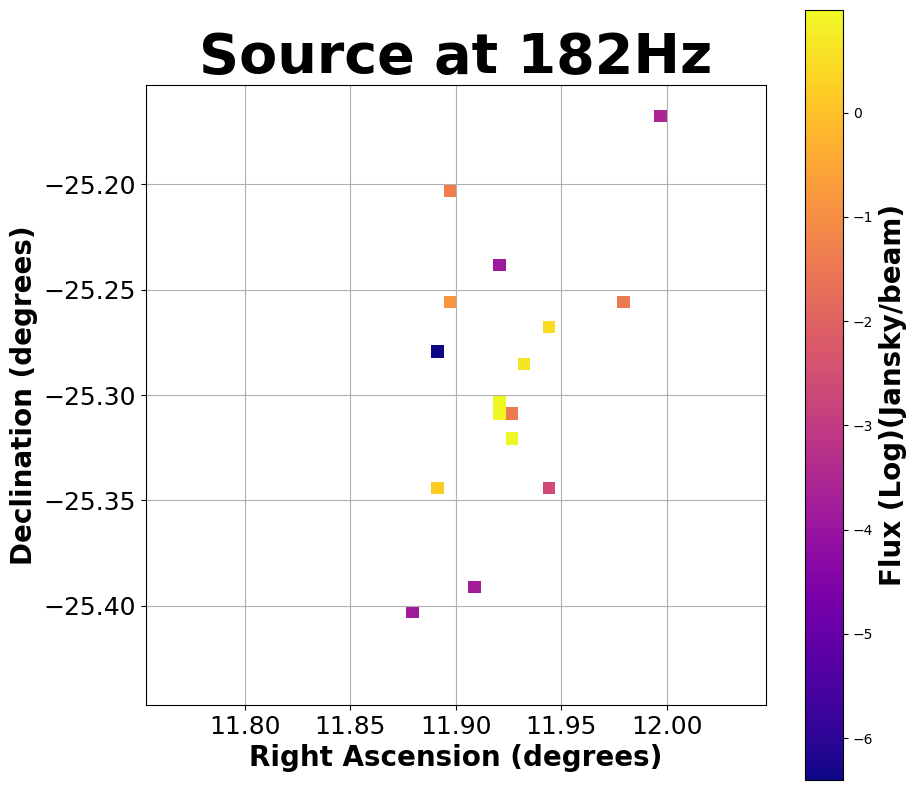

10.794662920868618 13.820906475007058


/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_54854/771039689.py:80: RuntimeWarning: Mean of empty slice
  alpha_pl = np.nanmean(new_catalog['ALPHA_PL'][inds_source_i])
/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_54854/771039689.py:108: RuntimeWarning: divide by zero encountered in log
  cax = ax.imshow(np.log(pixels_source), interpolation = "nearest", origin = "lower", cmap = "plasma",


<Figure size 1000x1000 with 0 Axes>

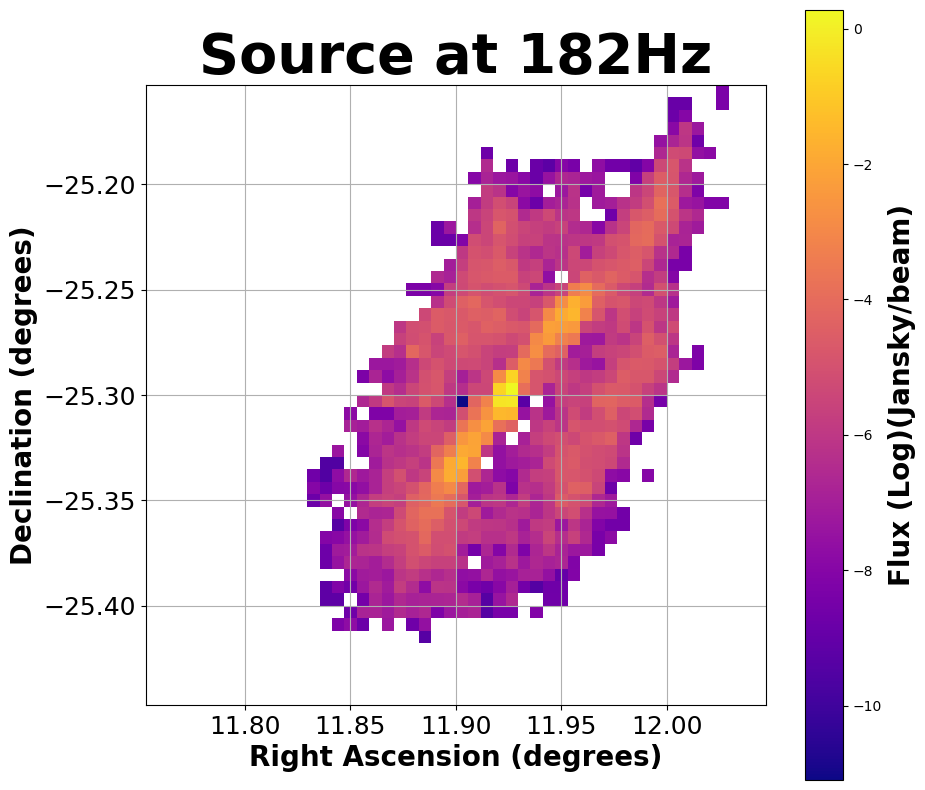

In [118]:
file_path = '/Users/nicholebarry/MWA/data/Deconvolution/srclist_pumav3_EoR0LoBES_EoR1pietro_CenA-GP_2023-11-07.fits'

with fits.open(file_path) as hdul:
    catalog = hdul[1].data  # Assuming the catalog is in the first extension
    header = hdul[1].header
    hdul.info()

# Create a new FITS table with the updated ra_array and dec_array
new_catalog = catalog.copy()

# Convert to an Astropy Table
table = Table(catalog)
# print(header)

# Print the column names
#print(table.colnames)

for source_i in range(1):

    source_i=9
    print(source_i)
    
    # Adjust RA values greater than 180
    inds_ra = np.where(new_catalog['ra'] > 180)
    new_catalog['ra'][inds_ra] -= 360

    ra_array = np.array(ra[source_i][1:], dtype=float)
    len_ra_array = len(ra_array)
    #print(len_ra_array)
    #print(np.min(ra_array))
    dec_array = np.array(dec[source_i][1:], dtype=float)
    flux_array = np.array(flux[source_i][1:], dtype=float)
    
    max_ra = np.max(np.array(ra_mm[source_i][1:], dtype=float))
    min_ra = np.min(np.array(ra_mm[source_i][1:], dtype=float))
    if max_ra > 180:
        max_ra -= 360
    if min_ra > 180:
        min_ra -= 360

    max_dec = np.max(np.array(dec_mm[source_i][1:], dtype=float))
    min_dec = np.min(np.array(dec_mm[source_i][1:], dtype=float))
#     print(min_ra, max_ra)
#     print(min_dec, max_dec)
    
#    inds_source_i = np.where((new_catalog['ra'] > min_ra) & (new_catalog['ra'] < max_ra) & 
#                              (new_catalog['dec'] > min_dec) & (new_catalog['dec'] < max_dec))

    inds_source_i = np.where((new_catalog['UNQ_SOURCE_ID'] == 'COM004733-2517'))
    
    
    n_bins_plot = 50
    max_i = np.where(new_catalog['NORM_COMP_CPL'][inds_source_i] == np.nanmax(new_catalog['NORM_COMP_CPL'][inds_source_i]))
    print(np.nanmax(new_catalog['NORM_COMP_CPL'][inds_source_i]),new_catalog['ra'][inds_source_i][max_i],new_catalog['dec'][inds_source_i][max_i])
    pixels_source, ra_pixel_centers_source, dec_pixel_centers_source = pixelate(ra_sources[source_i], dec_sources[source_i], n_bins_plot, new_catalog['ra'][inds_source_i], new_catalog['dec'][inds_source_i], new_catalog['UNQ_SOURCE_ID'][inds_source_i], new_catalog['NORM_COMP_CPL'][inds_source_i])   
    #figsize scales the plot, in this case i chose 10,10 square so its relatively big and easy to see!
    plt.figure(figsize=(1,1))
# Plot the image with the specified background color
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(np.log(pixels_source), interpolation = "nearest", origin = "lower", cmap = "plasma",
                extent=[ra_pixel_centers_source[0], ra_pixel_centers_source[-1], 
                        dec_pixel_centers_source[0], dec_pixel_centers_source[-1]])
# Set labels and title with desired font sizes
    ax.set_xlabel('Right Ascension (degrees)', fontweight='bold', size=20)
    ax.set_ylabel('Declination (degrees)', fontweight='bold', size=20)
    ax.set_title('Source at 182Hz', fontweight='bold', size=40)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
# Add colorbar
    cbar = fig.colorbar(cax)
    cbar.set_label('Flux (Log)(Jansky/beam)', size=20, fontweight='bold')
# Add grid
    ax.grid(True)
# Show the plot
    plt.show()
    
    
    
    
    alpha_pl = np.nanmean(new_catalog['ALPHA_PL'][inds_source_i])
    alpha_cpl = np.nanmean(new_catalog['ALPHA_CPL'][inds_source_i])
    alpha = np.nanmean([alpha_pl, alpha_cpl])
    new_flux = flux_array #* (200.0 / 182.435) ** alpha
#     print(inds_source_i)
    print(np.nansum(new_flux), np.nansum([new_catalog['NORM_COMP_PL'][inds_source_i], new_catalog['NORM_COMP_CPL'][inds_source_i]]))
#     print(new_catalog['UNQ_SOURCE_ID'][inds_source_i])
    
    inds_keep = np.where((new_catalog['ra'] < min_ra) | (new_catalog['ra'] > max_ra) & 
                        (new_catalog['dec'] < min_dec) | (new_catalog['dec'] > max_dec))
    #inds_keep = np.where((new_catalog['dec'] < min_dec) & (new_catalog['dec'] > max_dec))

    
    new_catalog['ra'][inds_ra] += 360
    
    new_ids = np.array(['GA' + str(i) for i in range(len(ra_array))])
    new_COMP_TYPE = np.array(['P' for i in range(len(ra_array))])
    new_MOD_TYPE = np.array(['pl' for i in range(len(ra_array))])

    
    
    
    max_i = np.where(new_flux == np.nanmax(new_flux))
    pixels_source, ra_pixel_centers_source, dec_pixel_centers_source = pixelate(ra_sources[source_i], dec_sources[source_i], n_bins_plot, ra_array, dec_array, new_ids, new_flux)   
    #figsize scales the plot, in this case i chose 10,10 square so its relatively big and easy to see!
    plt.figure(figsize=(10,10))
# Plot the image with the specified background color
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(np.log(pixels_source), interpolation = "nearest", origin = "lower", cmap = "plasma",
                extent=[ra_pixel_centers_source[0], ra_pixel_centers_source[-1], 
                        dec_pixel_centers_source[0], dec_pixel_centers_source[-1]])
# Set labels and title with desired font sizes
    ax.set_xlabel('Right Ascension (degrees)', fontweight='bold', size=20)
    ax.set_ylabel('Declination (degrees)', fontweight='bold', size=20)
    ax.set_title('Source at 182Hz', fontweight='bold', size=40)
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
# Add colorbar
    cbar = fig.colorbar(cax)
    cbar.set_label('Flux (Log)(Jansky/beam)', size=20, fontweight='bold')
# Add grid
    ax.grid(True)
# Show the plot
    plt.show()
    
    
    
    
    id_array = np.concatenate([new_catalog['UNQ_SOURCE_ID'][inds_keep], new_ids])
    ra_array = np.concatenate([new_catalog['ra'][inds_keep], ra_array])
    dec_array = np.concatenate([new_catalog['dec'][inds_keep], dec_array])
    flux_array = np.concatenate([new_catalog['NORM_COMP_PL'][inds_keep], new_flux])
    alpha_array = np.concatenate([new_catalog['ALPHA_PL'][inds_keep], np.full(len_ra_array, alpha)])
    
    name_array = np.concatenate([new_catalog['NAME'][inds_keep], np.zeros(len_ra_array)])
    MAJOR_DC_array = np.concatenate([new_catalog['MAJOR_DC'][inds_keep], np.zeros(len_ra_array)])
    MINOR_DC_array = np.concatenate([new_catalog['MINOR_DC'][inds_keep], np.zeros(len_ra_array)])
    PA_DC_array = np.concatenate([new_catalog['PA_DC'][inds_keep], np.zeros(len_ra_array)])
    MOD_TYPE_array = np.concatenate([new_catalog['MOD_TYPE'][inds_keep], new_MOD_TYPE])
    COMP_TYPE_array = np.concatenate([new_catalog['COMP_TYPE'][inds_keep], new_COMP_TYPE])
    norm_comp_cpl_array = np.concatenate([new_catalog['NORM_COMP_CPL'][inds_keep], np.zeros(len_ra_array)])
    ALPHA_CPL_array = np.concatenate([new_catalog['ALPHA_CPL'][inds_keep], np.zeros(len_ra_array)])
    CURVE_CPL_array = np.concatenate([new_catalog['CURVE_CPL'][inds_keep], np.zeros(len_ra_array)])

    # Create new FITS columns
    id_col = Column(name='UNQ_SOURCE_ID', data=id_array, format='16A')
    name_col = Column(name='NAME', data=name_array, format='20A')
    ra_col = Column(name='ra', data=ra_array, format='D')
    dec_col = Column(name='dec', data=dec_array, format='D')
    major_dc_col = Column(name='MAJOR_DC', data=MAJOR_DC_array, format='D')
    minor_dc_col = Column(name='MINOR_DC', data=MINOR_DC_array, format='D')
    pa_dc_col = Column(name='PA_DC', data=PA_DC_array, format='D')
    mod_type_col = Column(name='MOD_TYPE', data=MOD_TYPE_array, format='3A')
    comp_type_col = Column(name='COMP_TYPE', data=COMP_TYPE_array, format='1A')
    flux_col = Column(name='NORM_COMP_PL', data=flux_array, format='D')
    alpha_col = Column(name='ALPHA_PL', data=alpha_array, format='D')
    norm_comp_cpl_col = Column(name='NORM_COMP_CPL', data=norm_comp_cpl_array, format='D')
    alpha_cpl_col = Column(name='ALPHA_CPL', data=ALPHA_CPL_array, format='D')
    curve_cpl_col = Column(name='CURVE_CPL', data=CURVE_CPL_array, format='D')


    
    # Create a new FITS table with these columns
    new_catalog = Table([id_col, name_col, ra_col, dec_col, major_dc_col, minor_dc_col, pa_dc_col, mod_type_col, comp_type_col, flux_col, alpha_col, norm_comp_cpl_col, alpha_cpl_col, curve_cpl_col])

    
    # new_catalog['UNQ_SOURCE_ID'] = id_array
    # new_catalog['RA'] = ra_array
    # new_catalog['DEC'] = dec_array
    # new_catalog['NORM_COMP_PL'] = flux_array
    # new_catalog['ALPHA_PL'] = alpha_array
    # new_catalog['NAME'] = name_array
    # new_catalog['MAJOR_DC'] = MAJOR_DC_array
    # new_catalog['MINOR_DC'] = MINOR_DC_array
    # new_catalog['PC_DC'] = PA_DC_array
    # new_catalog['MOD_TYPE'] = MOD_TYPE_array
    # new_catalog['COMP_TYPE'] = COMP_TYPE_array
    # new_catalog['ALPHA_CPL'] = ALPHA_CPL_array
    # new_catalog['CURVE_CPL'] = CURVE_CPL_array



    # # Create a new FITS HDU (Header/Data Unit) with the updated data
    # new_hdu = fits.BinTableHDU(data=new_data, header=original_header)
    
    # # Write the new FITS file
    # new_file_path = 'path_to_your_new_fits_file.fits'
    # new_hdu.writeto(new_file_path, overwrite=True)


# Create a new FITS HDU (Header/Data Unit) with the updated data

    # Create a new FITS HDU (Header/Data Unit) with these columns
id_col = fits.Column(name='UNQ_SOURCE_ID', array=id_array, format='16A')
name_col = fits.Column(name='NAME', array=name_array, format='20A')
ra_col = fits.Column(name='RA', array=ra_array, format='D')
dec_col = fits.Column(name='DEC', array=dec_array, format='D')
major_dc_col = fits.Column(name='MAJOR_DC', array=MAJOR_DC_array, format='D')
minor_dc_col = fits.Column(name='MINOR_DC', array=MINOR_DC_array, format='D')
pa_dc_col = fits.Column(name='PA_DC', array=PA_DC_array, format='D')
mod_type_col = fits.Column(name='MOD_TYPE', array=MOD_TYPE_array, format='3A')
comp_type_col = fits.Column(name='COMP_TYPE', array=COMP_TYPE_array, format='1A')
flux_col = fits.Column(name='NORM_COMP_PL', array=flux_array, format='D')
alpha_col = fits.Column(name='ALPHA_PL', array=alpha_array, format='D')
norm_comp_cpl_col = fits.Column(name='NORM_COMP_CPL', array=norm_comp_cpl_array, format='D')
alpha_cpl_col = fits.Column(name='ALPHA_CPL', array=ALPHA_CPL_array, format='D')
curve_cpl_col = fits.Column(name='CURVE_CPL', array=CURVE_CPL_array, format='D')
cols = fits.ColDefs([id_col, name_col, ra_col, dec_col, major_dc_col, minor_dc_col, pa_dc_col, mod_type_col, comp_type_col, flux_col, alpha_col, norm_comp_cpl_col, alpha_cpl_col, curve_cpl_col])
new_hdu = fits.BinTableHDU.from_columns(cols)

# Update the header to match the new columns
new_hdu.header.extend(header, update=True)



# Write the new FITS file
new_file_path = '/Users/nicholebarry/MWA/data/Deconvolution/srclist_pumav3_EoR0LoBES_EoR1pietro_CenA-GP_2023-11-07_GA40_90_1_1e-5_ns.fits'
new_hdu.writeto(new_file_path, overwrite=True)



In [123]:
file_path = '/Users/z3543600/Downloads/flux_data_fixed/srclist_pumav3_EoR0LoBES_EoR1pietro_CenA-GP_2023-11-07_GA8_90_1_smaller.fits'

with fits.open(file_path) as hdul:
    catalog = hdul[1].data  # Assuming the catalog is in the first extension
    header = hdul[1].header
    hdul.info()
    print(header)

Filename: /Users/z3543600/Downloads/flux_data_fixed/srclist_pumav3_EoR0LoBES_EoR1pietro_CenA-GP_2023-11-07_GA8_90_1_smaller.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     34   352335R x 13C   ['16A', '20A', 'D', 'D', 'D', 'D', 'D', '3A', '1A', 'D', 'D', 'D', 'D']   
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  112 / length of dimension 1                          NAXIS2  =               352335 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   13 / number of table fields          